## Dataset Requirements

### Sufficient Volume and Variety
- The dataset must be expansive and diverse to encompass the variety of features and scenarios that the CubeSat will encounter. This includes capturing different landforms, weather conditions, and varying lighting situations.

### High Quality and Resolution
- Images within the dataset must maintain high quality and resolution to enable precise identification and determination of landmark coordinates by the model.

### Labelled Data
- It is essential for the dataset to be accurately labelled with the correct latitude and longitude coordinates. This will facilitate the model in making exact predictions.

### Balanced Classes
- A balanced representation of different landmark types is required within the dataset to prevent any biases in the model's learning process.

### Preprocessing
- Consistency in image size, orientation, and other influential factors is critical. The dataset must undergo preprocessing to ensure this uniformity, which is crucial for the model's performance.

### Data Augmentation
- The dataset should incorporate augmented data that represents a variety of operational conditions, like diverse angles, lighting scenarios, and potential occlusions (for instance, cloud cover), to bolster the model's robustness.

### Noise Filtering
- Noise elements, such as cloud interference or atmospheric distortions present in raw satellite imagery, should be filtered out to improve data clarity.

### Metadata
- Accompanying metadata is vital for each image, detailing the capture time, camera settings, and other pertinent information that can assist in the training process.

### Data Integrity and Versioning
- Mechanisms to ensure data integrity and maintain dataset versioning are crucial. This will help track alterations and updates over time.

### Updating and Maintenance
- The dataset requires regular updates and maintenance to incorporate new data and discard any that have become outdated or irrelevant.

### Access and Sharing
- Ease of access for the relevant teams is essential for the dataset. Additionally, provisions should be made for sharing capabilities with partners or stakeholders, in adherence to data sharing policies and agreements.

---

# Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [3]:
!pip install affine rasterio >/dev/null

In [4]:
import re
from osgeo import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import cos, sin, radians, sqrt
from affine import Affine
from PIL import Image
from tqdm import tqdm
import rasterio as rio
from rasterio.warp import reproject, Resampling
import matplotlib.patches as patches
import tifffile as tiff
import cv2
import requests
import json
from pathlib import Path
import time
import os, sys

# Nevigate to Dataset Pipeline Directory

In [6]:
pwd

'/content'

In [10]:
cd /content/drive/MyDrive/Spacecraft-team-vision/

/content/drive/MyDrive/Spacecraft-team-vision


In [11]:
ls

'camera & computer surveys'/   New_LandSat_Data/   WRS-2_reduced_regions_coordinates.zip
'LandSat Sample Data'/        'quad chart'/


In [15]:
#!unzip /content/drive/MyDrive/Spacecraft-team-vision/WRS-2_reduced_regions_coordinates.zip

In [14]:
ls WRS-2_reduced_regions_coordinates/

WRS-2_R101_R105_Regions/  WRS-2_R31_R35_Regions/  WRS-2_R71_R75_Regions/
WRS-2_R106_R110_Regions/  WRS-2_R36_R40_Regions/  WRS-2_R76_R80_Regions/
WRS-2_R111_R115_Regions/  WRS-2_R41_R45_Regions/  WRS-2_R81_R85_Regions/
WRS-2_R116_R120_Regions/  WRS-2_R46_R50_Regions/  WRS-2_R86_R90_Regions/
WRS-2_R11_R15_Regions/    WRS-2_R51_R55_Regions/  WRS-2_R91_R95_Regions/
WRS-2_R16_R20_Regions/    WRS-2_R56_R60_Regions/  WRS-2_R96_R100_Regions/
WRS-2_R1_R5_Regions/      WRS-2_R61_R65_Regions/  WRS-2_reduced_regions_all_placemarks.csv
WRS-2_R21_R25_Regions/    WRS-2_R66_R70_Regions/
WRS-2_R26_R30_Regions/    WRS-2_R6_R10_Regions/


# Data Collection


### M2M API Utility Functions

In [111]:
# utility function to post request to M2M API
def post_request(endpoint, data, auth_token = None):
    while True:
      login_url = 'https://m2m.cr.usgs.gov/api/api/json/stable/' + endpoint
      headers = {
          'X-Auth-Token': auth_token
      }
      try:
        response = requests.post(login_url, json=data, headers=headers)
        if response.status_code == 200:
          response = response.json()
          response = json.dumps(response, indent=4)
          return response
      except:
        print("--------------")
        print(response)
        print("Error making post request " + endpoint)
      global api_key
      api_key = json.loads(post_request("login", login_data))['data']
      auth_token = api_key

# read in the csv file for the bounding box
def get_coordinates_from_csv(input_csv_file):
    # read in csv file for the bounding box
    coordinates = pd.read_csv(input_csv_file)

    # initialize the output coordinates
    output_coordinates = []

    # iterate through the csv file to get the coordinates
    for index, row in coordinates.iterrows():
        output_coordinate_i = {}
        output_coordinate_i['LL Lat'] = row['LL Lat']
        output_coordinate_i['LL Lon'] = row['LL Lon']
        output_coordinate_i['UR Lat'] = row['UR Lat']
        output_coordinate_i['UR Lon'] = row['UR Lon']
        output_coordinates.append(output_coordinate_i)

    return output_coordinates

  # given a list of coordinates, get the scenes
def get_scenes(coordinates):
    # iterate through the coordinates to get the scenes
    global scene_data
    global api_key
    scene_search_responses = []
    for coordinate_i in coordinates:
        scene_data["sceneFilter"]["spatialFilter"]["lowerLeft"]["latitude"] = coordinate_i['LL Lat']
        scene_data["sceneFilter"]["spatialFilter"]["lowerLeft"]["longitude"] = coordinate_i['LL Lon']
        scene_data["sceneFilter"]["spatialFilter"]["upperRight"]["latitude"] = coordinate_i['UR Lat']
        scene_data["sceneFilter"]["spatialFilter"]["upperRight"]["longitude"] = coordinate_i['UR Lon']
        scene_search_response = post_request("scene-search",scene_data,api_key)
        # print("The length of the result is "+ str(json.loads(scene_search_response)['data']['recordsReturned']))
        scene_search_responses.append(scene_search_response)
    return scene_search_responses

  # given a list of scenes, get the images
def get_images_id_from_scenes(scenes):
    global num_images_per_scene
    top_resutls_list = {}
    for scene_i in scenes:
        results_list = json.loads(scene_i)['data']['results']
        results_list_len = min(num_images_per_scene,len(results_list))
        for i in range(results_list_len):
            data_entity_id = results_list[i]['entityId']
            download_options = post_request("download-options",{"datasetName":dataset_name,"entityIds":[data_entity_id]},api_key)
            download_options = json.loads(download_options)
            top_resutls_list[data_entity_id] = []
            for image_i in download_options['data'][0]["secondaryDownloads"]:
                if image_i['entityId'].endswith('B2_TIF') or image_i['entityId'].endswith('B3_TIF') or image_i['entityId'].endswith('B4_TIF') or image_i['entityId'].endswith('MTL_TXT'):
                    top_resutls_list[data_entity_id].append({
                        "entityId": image_i['entityId'],
                        "productId":image_i['id']
                    })
            if len(top_resutls_list[data_entity_id]) != 4:
                print("Error: the length of the top_resutls_list[data_entity_id] is not 4")
        # download_options['data'] will return several download sources, we just pick the first one as [0]
    return top_resutls_list

# get the download links for the images
# notice the links may not be valid instantly, you may need to wait for several seconds
def get_download_links(top_resutls_lists):
    # Iterate through the top_resutls_lists dictionary to download the images
    download_links = {}
    for scene_id, result_list_i in top_resutls_lists.items():
        for item in result_list_i:
            entityId = item['entityId']
            download_args = {"downloads": [item]}  # Assuming you need to pass a list of entityIds
            download = post_request("download-request", download_args, api_key)
            download_links[entityId] = download  # Use entityId as the key in download_links
    return download_links

#  get the download data for the images
def get_download_data(download_links, path):
    for scene_id, download_link_i in download_links.items():
        # Parse the JSON data
        download_data = json.loads(download_link_i)
        # iterate the available downloads
        for download_data_i in download_data['data']['availableDownloads']:
            # Extract the download URL for the first file
            download_url = download_data_i['url']

            # Save the file to your laptop
            response = requests.get(download_url)
            if response.status_code == 200:
                # print(path + str(scene_id) + "_" + str(download_data_i['downloadId'])+' .TIF', 'wb')
                os.makedirs(path, exist_ok=True)

                # Check and modify the file extension of scene_id
                if scene_id.endswith('_TIF'):
                    filename = scene_id.replace('_TIF', '.TIF')
                elif scene_id.endswith('_TXT'):
                    filename = scene_id.replace('_TXT', '.txt')
                else:
                    filename = scene_id

                with open(os.path.join(path, filename), 'wb') as file:
                    file.write(response.content)
                global num_downloaded_files
                num_downloaded_files +=1
                global start_time
                curr_time = time.time()
            else:
                print("Failed to download the file.")

In [109]:
import shutil

# Function to clean up downloaded data when testing
def delete_data_folders(path='WRS-2_reduced_regions_coordinates/'):
    # Walk through the directory
    for root, dirs, files in os.walk(path, topdown=False):
        # Iterate over each directory in the current root directory
        for dir_name in dirs:
            # Check if the directory name ends with '_Data'
            if dir_name.endswith('_Data'):
                # Construct the full path to the directory
                full_dir_path = os.path.join(root, dir_name)
                # Remove the directory and all its contents
                shutil.rmtree(full_dir_path)
                print(f"Deleted {full_dir_path}")

# Call the function
# delete_data_folders()

Deleted WRS-2_reduced_regions_coordinates/WRS-2_R1_R5_Regions/R1_R5_P1_P5_Data


### API key & Download Configurations

In [26]:
# the following is the login data for the M2M API
# notice the TODOs, you need to replace them with your own username and password
login_data = {
    "username": "tongjin",
    "password": "Link9jintong"
}

# the identifier for the dataset we will be using
dataset_id = "5e81f14f59432a27"
dataset_name = "landsat_ot_c2_l1"

# the csv file containing the list of scenes we want to download
# below is one example
csv_file = "WRS-2_reduced_regions_coordinates\WRS-2_R56_R60_Regions\R56_R60_P6_P10_coordinates.csv"

# default scene search json
# program will update the spatial filter's coordinates
# you can change other parameters if you want, such as cloud cover and time range
scene_data ={
    "maxResults": 10000,
    "datasetName": dataset_name,
    "sceneFilter": {
        "spatialFilter": {
            "filterType": "mbr",
            "lowerLeft": {
                "latitude": 0,
                "longitude":  0
            },
            "upperRight": {
                    "latitude": 0,
                    "longitude": 0
            }
        },
        "metadataFilter": None,
        "cloudCoverFilter": {
            "max": 10,
            "min": 0,
            "includeUnknown": False
        },
        "acquisitionFilter": {
            "end": "2023-11-06",
            "start": "2022-01-01"
        }
    },
    "metadataType": "summary",
}

# the number of images we want to download for each scene
num_images_per_scene = 3

In [24]:
# Login to get the API key
# Notice the api key is valid for only a few hours
# Need to rerun this cell if the api key is expired
api_key = json.loads(post_request("login", login_data))['data']
api_key

'eyJjaWQiOjI2OTQxNDg3LCJzIjoiMTcwMDY4NzA0OCIsInIiOjE3OSwicCI6WyJ1c2VyIiwiZG93bmxvYWQiLCJvcmRlciJdfQ=='

### Test Download with few LandSat Scenes (Hidden for complete Dataset Pipeline)

In [69]:
ls WRS-2_reduced_regions_coordinates/

WRS-2_R101_R105_Regions/  WRS-2_R31_R35_Regions/  WRS-2_R71_R75_Regions/
WRS-2_R106_R110_Regions/  WRS-2_R36_R40_Regions/  WRS-2_R76_R80_Regions/
WRS-2_R111_R115_Regions/  WRS-2_R41_R45_Regions/  WRS-2_R81_R85_Regions/
WRS-2_R116_R120_Regions/  WRS-2_R46_R50_Regions/  WRS-2_R86_R90_Regions/
WRS-2_R11_R15_Regions/    WRS-2_R51_R55_Regions/  WRS-2_R91_R95_Regions/
WRS-2_R16_R20_Regions/    WRS-2_R56_R60_Regions/  WRS-2_R96_R100_Regions/
WRS-2_R1_R5_Regions/      WRS-2_R61_R65_Regions/  WRS-2_reduced_regions_all_placemarks.csv
WRS-2_R21_R25_Regions/    WRS-2_R66_R70_Regions/
WRS-2_R26_R30_Regions/    WRS-2_R6_R10_Regions/


In [70]:
ls WRS-2_reduced_regions_coordinates/WRS-2_R101_R105_Regions/

R101_R105_P214_P218_coordinates.csv


In [83]:
csv_file = 'WRS-2_reduced_regions_coordinates/WRS-2_R1_R5_Regions/R1_R5_P1_P5_coordinates.csv'

In [72]:
output_coordinates = get_coordinates_from_csv(csv_file)
print(output_coordinates)
print("----------------------")
scene_search_responses = get_scenes(output_coordinates)
print(scene_search_responses)
print("----------------------")
images_for_each_scene = get_images_id_from_scenes(scene_search_responses)
print(images_for_each_scene)
print("----------------------")

[{'LL Lat': -0.685, 'LL Lon': -81.071, 'UR Lat': 0.685, 'UR Lon': -79.031}, {'LL Lat': 0.762, 'LL Lon': -80.764, 'UR Lat': 2.131, 'UR Lon': -78.723}, {'LL Lat': 5.101, 'LL Lon': -78.299, 'UR Lat': 6.468, 'UR Lon': -76.248}, {'LL Lat': 3.654, 'LL Lon': -78.606, 'UR Lat': 5.023, 'UR Lon': -76.56}, {'LL Lat': 2.208, 'LL Lon': -78.912, 'UR Lat': 3.577, 'UR Lon': -76.869}, {'LL Lat': 0.762, 'LL Lon': -79.219, 'UR Lat': 2.131, 'UR Lon': -77.178}]
----------------------
['{\n    "requestId": 1527402613,\n    "version": "stable",\n    "sessionId": 254477176,\n    "data": {\n        "results": [\n            {\n                "browse": [\n                    {\n                        "id": "5e81f7d39594374",\n                        "browseRotationEnabled": null,\n                        "browseName": "Reflective Browse",\n                        "browsePath": "https://landsatlook.usgs.gov/gen-browse?size=rrb&type=refl&product_id=LC09_L1TP_011059_20230328_20230329_02_T1",\n                   

In [90]:
print(images_for_each_scene)
download_links = get_download_links(images_for_each_scene)
print(json.dumps(download_links, indent=4))

{'LC90110592023087LGN00': [{'entityId': 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_B2_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_B3_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_B4_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_MTL_TXT', 'productId': '5e8206bf6bc4a163'}], 'LC90110592022116LGN01': [{'entityId': 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_B2_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_B3_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_B4_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_MTL_TXT', 'productId': '5e8206bf6bc4a163'}], 'LC90100612022061LGN01': [{'entityId': 'L1_LC09_L1GT_010061_20220302_20230426_02_T2_B2_TIF', 'productId': '5e8206bf6bc4a163'}, {'entity

In [91]:
download_links.keys()

dict_keys(['L1_LC09_L1TP_011059_20230328_20230329_02_T1_B2_TIF', 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_B3_TIF', 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_B4_TIF', 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_MTL_TXT', 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_B2_TIF', 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_B3_TIF', 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_B4_TIF', 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_MTL_TXT', 'L1_LC09_L1GT_010061_20220302_20230426_02_T2_B2_TIF', 'L1_LC09_L1GT_010061_20220302_20230426_02_T2_B3_TIF', 'L1_LC09_L1GT_010061_20220302_20230426_02_T2_B4_TIF', 'L1_LC09_L1GT_010061_20220302_20230426_02_T2_MTL_TXT', 'L1_LC09_L1GT_010057_20230305_20230307_02_T2_B2_TIF', 'L1_LC09_L1GT_010057_20230305_20230307_02_T2_B3_TIF', 'L1_LC09_L1GT_010057_20230305_20230307_02_T2_B4_TIF', 'L1_LC09_L1GT_010057_20230305_20230307_02_T2_MTL_TXT', 'L1_LC08_L1TP_011055_20230131_20230208_02_T1_B2_TIF', 'L1_LC08_L1TP_011055_20230131_20230208_02_T1_B3_TIF', 'L1_LC08_L1TP

In [99]:
# this will download the images to your local machine
# we download the first scene for example here
#download_links = {"LC90110592023087LGN00" : download_links["LC90110592023087LGN00"]}
path = 'temp/'
get_download_data(dict(list(download_links.items())[:4]), path)

# Notice the metaldata is also downloaded as TIF file on your local machine
# This is because we can't tell the difference between the metadata and the image given the download link M2M API provides

{'requestId': 1527413277, 'version': 'stable', 'sessionId': 254495032, 'data': {'availableDownloads': [{'downloadId': 503562308, 'eulaCode': None, 'url': 'https://landsatlook.usgs.gov/data/collection02/level-1/standard/oli-tirs/2023/011/059/LC09_L1TP_011059_20230328_20230329_02_T1/LC09_L1TP_011059_20230328_20230329_02_T1_B2.TIF?requestSignature=eyJjb250YWN0SWQiOjI2OTQxNDg3LCJkb3dubG9hZElkIjo1MDM1NjIzMDgsImRhdGVHZW5lcmF0ZWQiOiIyMDIzLTExLTIyVDE3OjUyOjM5LTA2OjAwIiwiaWQiOiJMQzA5X0wxVFBfMDExMDU5XzIwMjMwMzI4XzIwMjMwMzI5XzAyX1QxX0IyLlRJRiIsInNpZ25hdHVyZSI6IiQ1JCRWRGZHNk9cL1Z6WmFYMDE2Tk96QlhOXC9uTXRvRlF3NGpoUzhDUEVwRy56LlwvIn0='}], 'duplicateProducts': [], 'preparingDownloads': [], 'failed': [], 'newRecords': {'503562308': 'm2m_1527413277_20231122175239'}, 'numInvalidScenes': 0}, 'errorCode': None, 'errorMessage': None}
{'requestId': 1527413283, 'version': 'stable', 'sessionId': 254495032, 'data': {'availableDownloads': [{'downloadId': 503562328, 'eulaCode': None, 'url': 'https://landsatlook.u

In [102]:
ls temp/

L1_LC09_L1TP_011059_20230328_20230329_02_T1_B2.TIF
L1_LC09_L1TP_011059_20230328_20230329_02_T1_B3.TIF
L1_LC09_L1TP_011059_20230328_20230329_02_T1_B4.TIF
L1_LC09_L1TP_011059_20230328_20230329_02_T1_MTL.txt


### Meta Download

#### Confirm directory

In [105]:
ls WRS-2_reduced_regions_coordinates

WRS-2_R101_R105_Regions/  WRS-2_R31_R35_Regions/  WRS-2_R71_R75_Regions/
WRS-2_R106_R110_Regions/  WRS-2_R36_R40_Regions/  WRS-2_R76_R80_Regions/
WRS-2_R111_R115_Regions/  WRS-2_R41_R45_Regions/  WRS-2_R81_R85_Regions/
WRS-2_R116_R120_Regions/  WRS-2_R46_R50_Regions/  WRS-2_R86_R90_Regions/
WRS-2_R11_R15_Regions/    WRS-2_R51_R55_Regions/  WRS-2_R91_R95_Regions/
WRS-2_R16_R20_Regions/    WRS-2_R56_R60_Regions/  WRS-2_R96_R100_Regions/
WRS-2_R1_R5_Regions/      WRS-2_R61_R65_Regions/  WRS-2_reduced_regions_all_placemarks.csv
WRS-2_R21_R25_Regions/    WRS-2_R66_R70_Regions/
WRS-2_R26_R30_Regions/    WRS-2_R6_R10_Regions/


In [106]:
def meta_download(csv_file, output):
    output_coordinates = get_coordinates_from_csv(csv_file)
    scene_search_responses = get_scenes(output_coordinates)
    images_for_each_scene = get_images_id_from_scenes(scene_search_responses)
    download_links = get_download_links(images_for_each_scene)
    # for k in tqdm(download_links.keys()):
    #     download_link = {k : download_links[k]}
    get_download_data(download_links, output)

#### Iterate through the regions, search and download LandSat Scenes by the coordinates given for each region. Iterate through the downloaded files and convert the metadata files to the correct format.

In [ ]:
# for dirs, folders, files in os.walk('/content/drive/MyDrive/Spacecraft-team-vision/New_LandSat_Data/WRS-2_reduced_regions_coordinates'):
start_time =  time.time()
for dirs, folders, files in tqdm(os.walk('WRS-2_reduced_regions_coordinates')):
    for _file in files:
        if _file.endswith('csv') and 'placemarks' not in _file:
            name = dirs + '/' + _file
            new_folder = _file.split('coordinates')[0][:-1]
            output_path = dirs + '/' + new_folder + '_Data/Cloud_Cover_None'

            path_parts = name.split(os.sep)
            desired_path = os.path.join(path_parts[-2], path_parts[-1])
            print(f"Downloading directory: {desired_path}")
            meta_download(name, output_path)

print(f"Operation completed in {time.time() - start_time:.2f} seconds.")

# Image Pre-processing

### Untility Functions

In [55]:
def rotate_raster(in_file,out_file, angle, shift_x=0, shift_y=0,adj_width=0, adj_height=0):
    """Rotate a raster image and save it to disk.
            in_file: path to input raster file
            out_file: path to output raster file
            angle: angle of rotation in degrees
            shift_x: shift in x direction
            shift_y: shift in y direction
            adj_width: adjust width of output raster
            adj_height: adjust height of output raster"""

    with rio.open(in_file) as src:

        # Get the old transform and crs
        src_transform = src.transform
        crs = src.crs

        # Affine transformations for rotation and translation
        rotate = Affine.rotation(angle)
        trans_x = Affine.translation(shift_x,0)
        trans_y = Affine.translation(0, -shift_y)

        # Combine affine transformations
        dst_transform = src_transform * rotate * trans_x * trans_y

        # Get band data
        band = np.array(src.read(1))

        # Get the new shape
        y,x = band.shape
        dst_height = y + adj_height
        dst_width = x + adj_width

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update(
            {
                "transform": dst_transform,
                "height": dst_height,
                "width": dst_width,
                "nodata": 0,
            }
        )

        # write to disk
        with rio.open(out_file, "w", **dst_kwargs) as dst:
            # reproject to new CRS

            reproject(source=band,
                        destination=rio.band(dst, 1),
                        src_transform=src_transform,
                        src_crs=crs,
                        dst_transform=dst_transform,
                        dst_crs=crs,
                        resampling=Resampling.nearest)


def rotate_raster2(in_file,out_file, angle, shift_x=0, shift_y=0,adj_width=0, adj_height=0):
    """Rotate a raster image and save it to disk.
            in_file: path to input raster file
            out_file: path to output raster file
            angle: angle of rotation in degrees
            shift_x: shift in x direction
            shift_y: shift in y direction
            adj_width: adjust width of output raster
            adj_height: adjust height of output raster"""

    with rio.open(in_file) as src:

        # Get the old transform and crs
        src_transform = src.transform
        crs = src.crs

        # Affine transformations for rotation and translation
        rotate = Affine.rotation(angle)
        trans_x = Affine.translation(shift_x,0)
        trans_y = Affine.translation(0, -shift_y)

        # Combine affine transformations
        dst_transform = src_transform * rotate * trans_x * trans_y

        # Get band data
        band = np.array(src.read(1))

        # Get the new shape
        y,x = band.shape
        dst_height = y + adj_height
        dst_width = x + adj_width

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update(
            {
                "transform": dst_transform,
                "height": dst_height,
                "width": dst_width,
                "nodata": 0,
            }
        )

        # write to disk
        with rio.open(out_file, "w", **dst_kwargs) as dst:
            # reproject to new CRS

            reproject(source=band,
                        destination=rio.band(dst, 1),
                        src_transform=src_transform,
                        src_crs=crs,
                        dst_transform=dst_transform,
                        dst_crs=crs,
                        resampling=Resampling.nearest)

def plot_with_star_marker(file_path, pixel_x, pixel_y, title):
    """Plot a raster file with a star marker on the point of interest."""
    with rio.open(file_path) as src:
        # Read the data
        data = src.read(1)

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(5, 5))

        # Display the image
        ax.imshow(data, cmap='pink')  # or any other colormap you prefer

        # Plot a star marker at the point of interest
        ax.plot(pixel_x, pixel_y, marker='*', color='red', markersize=15)  # Adjust markersize for visibility

        # Set title and turn off axis
        ax.set_title(title)
        ax.set_axis_off()

def rotate_pixel_position(x, y, angle, center_x, center_y):
    """Rotate a pixel position around a specified center."""
    angle_rad = np.radians(angle)
    translated_x = x - center_x
    translated_y = y - center_y
    rotated_x = translated_x * np.cos(angle_rad) - translated_y * np.sin(angle_rad)
    rotated_y = translated_x * np.sin(angle_rad) + translated_y * np.cos(angle_rad)
    return int(rotated_x + center_x), int(rotated_y + center_y)

def display(img):
    image = rio.open(img)
    plt.imshow(image.read(1))


def get_coordinates(transform, pixel_x, pixel_y):
    """Get geographic coordinates for given pixel positions."""
    longitude, latitude = (transform * (pixel_x, pixel_y))
    return (longitude, latitude)

def calculate_error(coords1, coords2):
    """Calculate the Euclidean distance between two sets of geographic coordinates."""
    return np.sqrt((coords1[0] - coords2[0])**2 + (coords1[1] - coords2[1])**2)


def crs_to_pixel_coords(affine_matrix, crs_x, crs_y):
    """
    Convert CRS coordinates to pixel coordinates.

    Args:
    affine_matrix (Affine): The affine transformation matrix.
    crs_x (float): The x-coordinate in CRS.
    crs_y (float): The y-coordinate in CRS.

    Returns:
    tuple: A tuple containing the pixel coordinates (x, y).
    """
    # Invert the affine matrix to transform from CRS to pixel coordinates
    inv_affine = ~affine_matrix
    pixel_coords = inv_affine * (crs_x, crs_y)
    return pixel_coords

## Single Example

(7711, 7541)


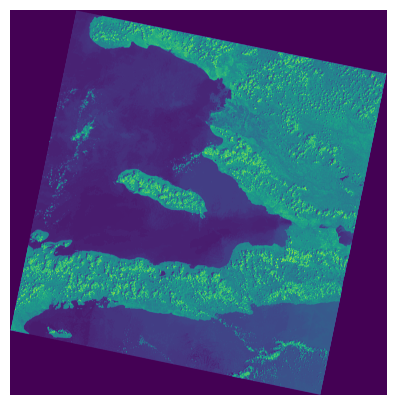

In [ ]:
# tif_path = '/content/drive/MyDrive/Spacecraft-team-vision/New_LandSat_Data/30_26/LC08_L2SP_025031_20230202_20230209_02_T1_SR_B2.TIF'
tif_path = '/content/drive/MyDrive/16873/landsat_c2_l1_sample/LC08_L1TP_009047_20230914_20230919_02_T1_refl.tif'
B4 = rio.open(tif_path)

print(B4.shape)

# Display the band
fig, ax = plt.subplots(figsize=(5, 5))
# ax.imshow(B4.read(1), cmap='pink')
ax.imshow(B4.read(1))

ax.set_axis_off()

In [ ]:
# ref: https://medium.com/p/dc36e42b01dd
print(B4.crs) # Gives coordinate reference system
print(B4.transform) # Affine transformation matrix

# convert array positions to UTM coordinates
x,y = (1000,2000)
utmx,utmy = B4.xy(y,x)
print("\n"+ str((utmx,utmy)))

EPSG:32618
| 30.00, 0.00, 614085.00|
| 0.00,-30.00, 2193915.00|
| 0.00, 0.00, 1.00|

(644100.0, 2133900.0)


In [ ]:
# pixel @ affine = CRS
# new_affine = pixel @ affine @ rotate @ trans_x @ trans_y
# Eg:
# pixel 2000, 3000 => CRS (674100.0, 2103900.0)
# rotate => new_affine (from rotate function) => original x,y coordinates still work after the new_affine transformation
# the pixel however could be trickier to find

Original Coordinates: (719100.0, 2103900.0)
Rotated Coordinates: (720051.2482238327, 2100849.677578783)
Rotated Coordinates 2: (720062.8017624815, 2100831.8866894096)


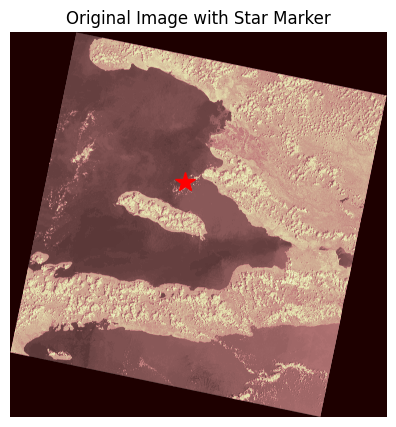

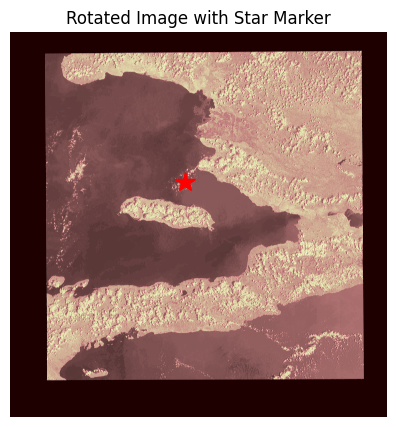

In [ ]:
# File paths, rotation angle, and pixel coordinates
in_file = tif_path
out_file = 'test.TIF'
rotate_angle = 12 # degrees
original_pixel_x, original_pixel_y = 3500, 3000  # Original point of interest

# Step 1: Get original geographic coordinates of input pixel
with rio.open(in_file) as src:
    # original_coords = get_coordinates(src.transform, original_pixel_x, original_pixel_y)
    original_coords = src.xy(original_pixel_y, original_pixel_x)
    # print(original_coords) # (674100.0, 2103900.0)

# Step 2: Rotate the raster
shift_x = 600
shift_y = 700
rotate_raster(in_file, out_file, rotate_angle, shift_x=600, shift_y=700)

# Step 3: Calculate new pixel position after rotation
with rio.open(out_file) as rotated_src:
    # width, height = rotated_src.width, rotated_src.height
    # center_x, center_y = (width + shift_x) / 2, (height + shift_y)/ 2
    # rotated_pixel_x, rotated_pixel_y = rotate_pixel_position(original_pixel_x, original_pixel_y, rotate_angle, center_x, center_y)

    # Step 4: Get geographic coordinates of the new position in the rotated image
    # rotated_coords = get_coordinates(rotated_src.transform, rotated_pixel_x, rotated_pixel_y)
    rotated_coords = get_coordinates(rotated_src.transform, original_pixel_x, original_pixel_y)
    crs_x, crs_y = rotated_coords[0], rotated_coords[1]
    rotated_pixel_x, rotated_pixel_y = crs_to_pixel_coords(rotated_src.transform, crs_x, crs_y)
    rotated_coords2 = rotated_src.xy(original_pixel_y, original_pixel_x)

# Step 5: Plot and compare
print("Original Coordinates:", original_coords)
print("Rotated Coordinates:", rotated_coords)
print("Rotated Coordinates 2:", rotated_coords2)

plot_with_star_marker(in_file, original_pixel_x, original_pixel_y, "Original Image with Star Marker")
plot_with_star_marker(out_file, rotated_pixel_x, rotated_pixel_y, "Rotated Image with Star Marker")

plt.show()

In [ ]:
end = calculate_error(original_coords, rotated_coords)
print("Error:", end) # 4142.844625072739 12 # 4517.8069415491445 11.2 # 15 5k

Error: 3195.2057925465783


Original CRS Coordinates: (719100.0, 2043900.0)
Rotated CRS Coordinates: (707576.5467747671, 2042160.8215347547)
Rotated CRS Coordinates 2: (707588.1003134159, 2042143.0306453814)


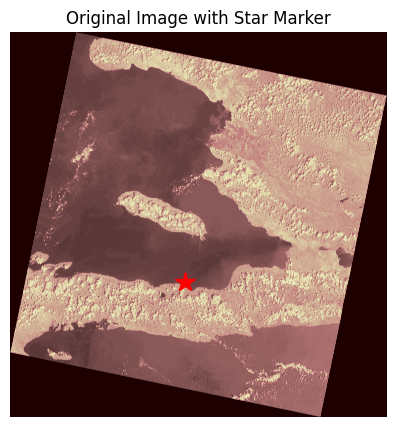

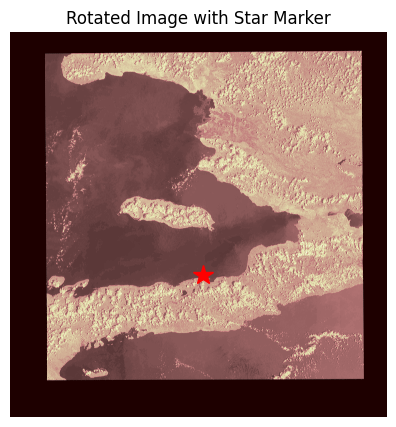

In [ ]:
# File paths, rotation angle, and pixel coordinates
in_file = tif_path
out_file = 'test.TIF'
rotate_angle = 12 # degrees
original_pixel_x, original_pixel_y = 3500, 5000  # Original point of interest

# Step 1: Get original geographic coordinates of input pixel
with rio.open(in_file) as src:
    # original_coords = get_coordinates(src.transform, original_pixel_x, original_pixel_y)
    original_coords = src.xy(original_pixel_y, original_pixel_x)
    # print(original_coords) # (674100.0, 2103900.0)

# Step 2: Rotate the raster
shift_x = 600
shift_y = 700
rotate_angle = 12
rotate_raster(in_file, out_file, rotate_angle=12, shift_x=600, shift_y=700)

# Step 3: Calculate new pixel position after rotation
with rio.open(out_file) as rotated_src:
    # width, height = rotated_src.width, rotated_src.height
    # center_x, center_y = (width + shift_x) / 2, (height + shift_y)/ 2
    # rotated_pixel_x, rotated_pixel_y = rotate_pixel_position(original_pixel_x, original_pixel_y, rotate_angle, center_x, center_y)

    # Step 4: Get geographic coordinates of the new position in the rotated image
    # rotated_coords = get_coordinates(rotated_src.transform, rotated_pixel_x, rotated_pixel_y)
    rotated_coords = get_coordinates(rotated_src.transform, original_pixel_x, original_pixel_y)
    crs_x, crs_y = original_coords[0], original_coords[1]
    rotated_pixel_x, rotated_pixel_y = crs_to_pixel_coords(rotated_src.transform, crs_x, crs_y)
    rotated_coords2 = rotated_src.xy(original_pixel_y, original_pixel_x)

# Step 5: Plot and compare
print("Original CRS Coordinates:", original_coords)
print("Rotated CRS Coordinates:", rotated_coords)
print("Rotated CRS Coordinates 2:", rotated_coords2)

plot_with_star_marker(in_file, original_pixel_x, original_pixel_y, "Original Image with Star Marker")
plot_with_star_marker(out_file, rotated_pixel_x, rotated_pixel_y, "Rotated Image with Star Marker")

plt.show()

## Complete Pipeline

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/13GkppKuD0hVUDdJ5Z03O4JkG7tQ1sfXF/Spacecraft-team-vision/New_LandSat_Data'

In [ ]:
cd /content/drive/MyDrive/Spacecraft-team-vision/New_LandSat_Data/WRS-2_reduced_regions_coordinates

/content/drive/.shortcut-targets-by-id/13GkppKuD0hVUDdJ5Z03O4JkG7tQ1sfXF/Spacecraft-team-vision/New_LandSat_Data/WRS-2_reduced_regions_coordinates


In [ ]:
ls

25_31.zip       40_26/               get_map.py
30_26/          40_26_rotated/       get_map_sage.py
30_26_rotated/  40_31/               label_encoder.pth
30_26.zip       40_31_rotated/       landsat_rgb_images/
30_31/          45_26/               landsat_rgb_images_png/
30_31_rotated/  45_26_rotated/       LC08_L2SP_025031_20230407_20230420_02_T1_MTL.xml
30_31.zip       45_31/               map.csv
35_26/          45_31_rotated/       map_sage.csv
35_26_rotated/  dummy/               model.pth
35_31/          file_paths_sage.txt  test.txt
35_31_rotated/  file_paths.txt       WRS-2_reduced_regions_coordinates/


In [ ]:
def save_file_paths(directory, output_file):
    with open(output_file, 'w') as file:
        for root, dirs, files in os.walk(directory):
            for name in files:
                file_path = os.path.join(root, name)
                file.write(file_path + '\n')

# Example usage
directory_to_scan = '/content/drive/MyDrive/Spacecraft-team-vision/New_LandSat_Data/WRS-2_reduced_regions_coordinates'  # Replace with your directory path
output_file = 'file_paths_new.txt'  # The file where the paths will be saved
save_file_paths(directory_to_scan, output_file)

In [ ]:
# cat file_paths_new.txt

In [ ]:
# https://towardsdatascience.com/how-to-plot-coordinates-on-landsat-satellite-images-with-python-5671613887aa
# https://github.com/conorosully/medium-articles/blob/master/src/remote%20sensing/landsat_GPS.ipynb
# https://github.com/conorosully/medium-articles/blob/master/src/remote%20sensing/landsat_cropping.ipynb
# 100 images = 15m
# 10000 images = 1500m ~ 25 hours
# 100.000 images = 15.000m ~ 250 hours
# Function to calculate the region label based on path and row
# def get_region_label(path, row, region_size=5):
#     # Calculate the region's starting path and row
#     start_path = path - path % region_size
#     start_row = row - row % region_size
#     end_path = start_path + region_size - 1
#     end_row = start_row + region_size - 1
#     # Format the label
#     return f"{start_path}{end_path}_{start_row}{end_row}"

# Read the file paths from the provided text file
file_paths_txt = './file_paths_new.txt'
with open(file_paths_txt, 'r') as file:
    all_paths = [line.strip() for line in file.readlines()]

def get_region_label(path, row):
    # Assuming the top right of the region starts at path 15 and row 26
    # and each region spans 5 paths and rows
    start_path = 15
    start_row = 26
    region_size = 5

    # Calculate the region's starting path and row based on the range
    region_start_path = start_path + ((path - start_path) // region_size) * region_size
    region_end_path = region_start_path + region_size - 1
    region_start_row = start_row + ((row - start_row) // region_size) * region_size
    region_end_row = region_start_row + region_size - 1

    # Format the label
    return f"{region_start_path}{region_end_path}_{region_start_row}{region_end_row}"

# A helper function to extract the unique ID from a file path
def extract_unique_id(file_path):
    # This regex pattern assumes that the unique ID is in the form 'LC08_L2SP_025031_20230202_20230209_02_T1'
    pattern = re.compile(r'LC08_L2SP_(\d{3})(\d{3})_\d{8}_\d{8}_\d{2}_T1')
    match = pattern.search(file_path)
    if match:
        path, row = map(int, match.groups())
        region_label = get_region_label(path, row)
        # print(file_path, region_label)
        return match.group(), region_label
    return None, None

# Function to resize image
def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

# Process each set of bands and save as an RGB image
base_output_folder = './landsat_rgb_images_png/'
if not os.path.exists(base_output_folder):
    os.makedirs(base_output_folder)

# rotate_raster(in_file, out_file, rotate_angle=12, shift_x=600, shift_y=700)

# OLD PROCESSING

# for path in tqdm(all_paths):
#     if path.endswith('.TIF') and 'rotated' not in path:
#         try:
#             unique_id, region_label = extract_unique_id(path)
#             # print(unique_id, region_label)
#             if unique_id:
#                 # Define the output folder for the region
#                 output_folder = os.path.join(base_output_folder, region_label)
#                 if not os.path.exists(output_folder):
#                     os.makedirs(output_folder)

#                 # Read and resize the band images
#                 band_files = {band: path for band in ['SR_B2', 'SR_B3', 'SR_B4']}
#                 # print(band_files)
#                 # print(band_files)
#                 for k in band_files.keys():
#                     in_file = band_files[k]
#                     out_file = band_files[k][:7]+'_rotated'+band_files[k][7:]
#                     # print(k, in_file, out_file)
#                     try:
#                       rotate_raster(in_file, out_file, angle=12.5, shift_x=600, shift_y=700)
#                     except:
#                       print(in_file, out_file, rotate_angle)
#                     band_files[k] = out_file

#                 # B2 = resize_image(tiff.imread(band_files['SR_B2']), 10) if 'SR_B2' in band_files else None
#                 # B3 = resize_image(tiff.imread(band_files['SR_B3']), 10) if 'SR_B3' in band_files else None
#                 # B4 = resize_image(tiff.imread(band_files['SR_B4']), 10) if 'SR_B4' in band_files else None

#                 B2 = resize_image(tiff.imread(band_files['SR_B2']), 100) if 'SR_B2' in band_files else None
#                 B3 = resize_image(tiff.imread(band_files['SR_B3']), 100) if 'SR_B3' in band_files else None
#                 B4 = resize_image(tiff.imread(band_files['SR_B4']), 100) if 'SR_B4' in band_files else None

#                 # Ensure that all bands are present
#                 if B2 is not None and B3 is not None and B4 is not None:
#                     # Stack and scale bands to create an RGB image
#                     RGB = np.dstack((B4, B3, B2))
#                     RGB = RGB.astype(np.float32)
#                     RGB = np.clip(RGB * 0.0000275 - 0.2, 0, 1)  # Apply scale factor and offset

#                     # Save the RGB image
#                     output_path = os.path.join(output_folder, f"{unique_id}_RGB.png")
#                     # print(output_path)
#                     Image.fromarray((RGB * 255).astype(np.uint8)).save(output_path)
#         except Exception as e:
#             print(f"Failed to process {path}: {e}")

# # Output the base path where the RGB images are saved by region
# print(base_output_folder)

###### NEW PROCESSING CODE #######
for path in tqdm(all_paths):
    if path.endswith('.TIF'):
        try:
            unique_id, region_label = extract_unique_id(path)
            # print(unique_id, region_label)
            if unique_id:
                # Define the output folder for the region
                output_folder = os.path.join(base_output_folder, region_label)
                if not os.path.exists(output_folder):
                    os.makedirs(output_folder)

                # Read and resize the band images
                band_files = {band: path for band in ['SR_B2', 'SR_B3', 'SR_B4']}
                # print(band_files)
                # print(band_files)
                for k in band_files.keys():
                    in_file = band_files[k]
                    out_file = band_files[k][:7]+'_rotated'+band_files[k][7:]
                    # print(k, in_file, out_file)
                    try:
                      rotate_raster(in_file, out_file, angle=12.5, shift_x=600, shift_y=700)
                    except:
                      print(in_file, out_file, rotate_angle)
                    band_files[k] = out_file

                # B2 = resize_image(tiff.imread(band_files['SR_B2']), 10) if 'SR_B2' in band_files else None
                # B3 = resize_image(tiff.imread(band_files['SR_B3']), 10) if 'SR_B3' in band_files else None
                # B4 = resize_image(tiff.imread(band_files['SR_B4']), 10) if 'SR_B4' in band_files else None

                print('so far it is OK')
                # B2 = resize_image(tiff.imread(band_files['SR_B2']), 100) if 'SR_B2' in band_files else None
                # B3 = resize_image(tiff.imread(band_files['SR_B3']), 100) if 'SR_B3' in band_files else None
                # B4 = resize_image(tiff.imread(band_files['SR_B4']), 100) if 'SR_B4' in band_files else None

                # # Ensure that all bands are present
                # if B2 is not None and B3 is not None and B4 is not None:
                #     # Stack and scale bands to create an RGB image
                #     RGB = np.dstack((B4, B3, B2))
                #     RGB = RGB.astype(np.float32)
                #     RGB = np.clip(RGB * 0.0000275 - 0.2, 0, 1)  # Apply scale factor and offset

                #     # Save the RGB image
                #     output_path = os.path.join(output_folder, f"{unique_id}_RGB.png")
                #     # print(output_path)
                #     Image.fromarray((RGB * 255).astype(np.uint8)).save(output_path)
        except Exception as e:
            print(f"Failed to process {path}: {e}")

# Output the base path where the RGB images are saved by region
print(base_output_folder)

  0%|          | 0/462 [00:00<?, ?it/s]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230715_20230724_02_T1_RGB.png


  2%|▏         | 9/462 [00:32<27:14,  3.61s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230512_20230518_02_T1_RGB.png


  3%|▎         | 12/462 [01:05<44:37,  5.95s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20231003_20231011_02_T1_RGB.png


  3%|▎         | 13/462 [01:37<1:11:21,  9.54s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230715_20230724_02_T1_RGB.png


  3%|▎         | 14/462 [02:08<1:36:41, 12.95s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230528_20230606_02_T1_RGB.png


  4%|▍         | 18/462 [02:39<1:17:34, 10.48s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230917_20230926_02_T1_RGB.png


  5%|▍         | 22/462 [03:08<1:06:38,  9.09s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230917_20230926_02_T1_RGB.png


  5%|▍         | 23/462 [03:37<1:25:02, 11.62s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230613_20230622_02_T1_RGB.png


  5%|▌         | 24/462 [04:07<1:45:11, 14.41s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230613_20230622_02_T1_RGB.png


  5%|▌         | 25/462 [04:36<2:03:54, 17.01s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230816_20230819_02_T1_RGB.png


  6%|▌         | 26/462 [05:11<2:31:08, 20.80s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230629_20230711_02_T1_RGB.png


  6%|▌         | 28/462 [05:42<2:16:14, 18.84s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230512_20230518_02_T1_RGB.png


  6%|▋         | 30/462 [06:13<2:06:58, 17.63s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230731_20230805_02_T1_RGB.png


  7%|▋         | 31/462 [06:47<2:30:42, 20.98s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230731_20230805_02_T1_RGB.png


  7%|▋         | 32/462 [07:21<2:50:24, 23.78s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230512_20230518_02_T1_RGB.png


  7%|▋         | 33/462 [07:53<3:03:39, 25.69s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230613_20230622_02_T1_RGB.png


  7%|▋         | 34/462 [08:25<3:14:17, 27.24s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230629_20230711_02_T1_RGB.png


  8%|▊         | 35/462 [08:56<3:22:43, 28.49s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230629_20230711_02_T1_RGB.png


  8%|▊         | 36/462 [09:28<3:27:41, 29.25s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230715_20230724_02_T1_RGB.png


  8%|▊         | 37/462 [09:55<3:23:51, 28.78s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230901_20230911_02_T1_RGB.png


  8%|▊         | 38/462 [10:28<3:31:03, 29.87s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230528_20230606_02_T1_RGB.png


  8%|▊         | 39/462 [10:58<3:31:43, 30.03s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230901_20230911_02_T1_RGB.png


  9%|▊         | 40/462 [11:29<3:33:35, 30.37s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230731_20230805_02_T1_RGB.png


  9%|▉         | 41/462 [12:01<3:34:51, 30.62s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230901_20230911_02_T1_RGB.png


  9%|▉         | 42/462 [12:30<3:32:36, 30.37s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230528_20230606_02_T1_RGB.png


  9%|▉         | 43/462 [12:59<3:27:36, 29.73s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230816_20230819_02_T1_RGB.png


 10%|▉         | 44/462 [13:28<3:26:44, 29.68s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230917_20230926_02_T1_RGB.png


 10%|▉         | 45/462 [14:00<3:30:09, 30.24s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20231003_20231011_02_T1_RGB.png


 10%|▉         | 46/462 [14:31<3:31:02, 30.44s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20230816_20230819_02_T1_RGB.png


 10%|█         | 47/462 [15:05<3:39:03, 31.67s/it]

./landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20231003_20231011_02_T1_RGB.png


 10%|█         | 48/462 [15:37<3:38:06, 31.61s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_039026_20230916_20230925_02_T1_RGB.png


 11%|█         | 49/462 [16:07<3:35:19, 31.28s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_039026_20230916_20230925_02_T1_RGB.png


 11%|█         | 50/462 [16:38<3:33:41, 31.12s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_039026_20230916_20230925_02_T1_RGB.png


 11%|█         | 51/462 [17:08<3:31:40, 30.90s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_037030_20230918_20230926_02_T1_RGB.png


 11%|█▏        | 52/462 [17:40<3:33:23, 31.23s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_037028_20230918_20230926_02_T1_RGB.png


 11%|█▏        | 53/462 [18:12<3:33:58, 31.39s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_035028_20231006_20231011_02_T1_RGB.png


 12%|█▏        | 54/462 [18:44<3:33:28, 31.39s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_035026_20231006_20231011_02_T1_RGB.png


 12%|█▏        | 55/462 [19:14<3:30:41, 31.06s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_035030_20231006_20231011_02_T1_RGB.png


 12%|█▏        | 56/462 [19:45<3:31:22, 31.24s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_036030_20230927_20231003_02_T1_RGB.png


 12%|█▏        | 57/462 [20:18<3:32:53, 31.54s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_035030_20231006_20231011_02_T1_RGB.png


 13%|█▎        | 62/462 [20:50<1:36:16, 14.44s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_035028_20231006_20231011_02_T1_RGB.png


 14%|█▍        | 64/462 [21:21<1:37:36, 14.72s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_036030_20230927_20231003_02_T1_RGB.png


 14%|█▍        | 65/462 [21:53<1:56:24, 17.59s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_039030_20230831_20230911_02_T1_RGB.png


 14%|█▍        | 66/462 [22:23<2:12:28, 20.07s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_039028_20230916_20230925_02_T1_RGB.png


 15%|█▍        | 67/462 [22:53<2:26:05, 22.19s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_037030_20230918_20230926_02_T1_RGB.png


 15%|█▍        | 68/462 [23:23<2:38:03, 24.07s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_039030_20230831_20230911_02_T1_RGB.png


 15%|█▍        | 69/462 [23:54<2:47:59, 25.65s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_035030_20231006_20231011_02_T1_RGB.png


 15%|█▌        | 70/462 [24:26<2:59:25, 27.46s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_039028_20230916_20230925_02_T1_RGB.png


 15%|█▌        | 71/462 [24:55<3:00:57, 27.77s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_039028_20230916_20230925_02_T1_RGB.png


 16%|█▌        | 72/462 [25:34<3:22:09, 31.10s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_035028_20231006_20231011_02_T1_RGB.png


 16%|█▌        | 73/462 [26:06<3:21:58, 31.15s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_036030_20230927_20231003_02_T1_RGB.png


 16%|█▌        | 74/462 [26:38<3:22:53, 31.37s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_035026_20231006_20231011_02_T1_RGB.png


 16%|█▌        | 75/462 [27:11<3:26:09, 31.96s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_037028_20230918_20230926_02_T1_RGB.png


 17%|█▋        | 78/462 [27:42<2:07:55, 19.99s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_035026_20231006_20231011_02_T1_RGB.png


 17%|█▋        | 80/462 [28:14<1:58:12, 18.57s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_037026_20230918_20230926_02_T1_RGB.png


 18%|█▊        | 81/462 [28:46<2:15:00, 21.26s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_037030_20230918_20230926_02_T1_RGB.png


 18%|█▊        | 84/462 [29:17<1:42:16, 16.23s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_037030_20230918_20230926_02_T1_RGB.png


 18%|█▊        | 85/462 [29:48<1:58:56, 18.93s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_039030_20230831_20230911_02_T1_RGB.png


 19%|█▊        | 86/462 [30:19<2:13:11, 21.25s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_037026_20230918_20230926_02_T1_RGB.png


 19%|█▉        | 87/462 [30:52<2:28:59, 23.84s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_037026_20230918_20230926_02_T1_RGB.png


 19%|█▉        | 88/462 [31:23<2:40:23, 25.73s/it]

./landsat_rgb_images_png/3539_2630/LC08_L2SP_037028_20230918_20230926_02_T1_RGB.png


 19%|█▉        | 89/462 [31:52<2:45:14, 26.58s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_039035_20230916_20230925_02_T1_RGB.png


 20%|█▉        | 91/462 [32:22<2:14:04, 21.68s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_037033_20231004_20231011_02_T1_RGB.png


 20%|█▉        | 92/462 [32:53<2:27:08, 23.86s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_035035_20230904_20230912_02_T1_RGB.png


 20%|██        | 93/462 [33:24<2:37:31, 25.61s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_037035_20231004_20231011_02_T1_RGB.png


 20%|██        | 94/462 [33:56<2:46:46, 27.19s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_039031_20230916_20230925_02_T1_RGB.png


 21%|██        | 95/462 [34:27<2:52:26, 28.19s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_035033_20231006_20231011_02_T1_RGB.png


 21%|██        | 97/462 [34:59<2:19:14, 22.89s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_035033_20231006_20231011_02_T1_RGB.png


 21%|██▏       | 99/462 [35:41<2:14:44, 22.27s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_039031_20230916_20230925_02_T1_RGB.png


 22%|██▏       | 100/462 [36:12<2:25:01, 24.04s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_035035_20230904_20230912_02_T1_RGB.png


 22%|██▏       | 102/462 [36:43<2:04:38, 20.77s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_037031_20230918_20230926_02_T1_RGB.png


 23%|██▎       | 104/462 [37:15<1:54:22, 19.17s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_037035_20231004_20231011_02_T1_RGB.png


 23%|██▎       | 105/462 [37:46<2:07:46, 21.47s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_035031_20231006_20231011_02_T1_RGB.png


 23%|██▎       | 108/462 [38:18<1:37:17, 16.49s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_035031_20231006_20231011_02_T1_RGB.png


 24%|██▎       | 109/462 [38:50<1:53:43, 19.33s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_039031_20230916_20230925_02_T1_RGB.png


 24%|██▍       | 110/462 [39:20<2:06:28, 21.56s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_035031_20231006_20231011_02_T1_RGB.png


 24%|██▍       | 111/462 [39:51<2:18:43, 23.71s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_037031_20230918_20230926_02_T1_RGB.png


 24%|██▍       | 112/462 [40:21<2:25:59, 25.03s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_039035_20230916_20230925_02_T1_RGB.png


 24%|██▍       | 113/462 [40:50<2:32:47, 26.27s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_037031_20230918_20230926_02_T1_RGB.png


 25%|██▍       | 114/462 [41:21<2:38:53, 27.40s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_035033_20231006_20231011_02_T1_RGB.png


 25%|██▍       | 115/462 [41:51<2:42:51, 28.16s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_039033_20230916_20230925_02_T1_RGB.png


 25%|██▌       | 116/462 [42:21<2:45:02, 28.62s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_039033_20230916_20230925_02_T1_RGB.png


 26%|██▌       | 118/462 [42:50<2:07:34, 22.25s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_035035_20230904_20230912_02_T1_RGB.png


 26%|██▌       | 119/462 [43:21<2:20:13, 24.53s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_038034_20230909_20230918_02_T1_RGB.png


 26%|██▌       | 120/462 [43:54<2:31:17, 26.54s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_039033_20230916_20230925_02_T1_RGB.png


 26%|██▌       | 121/462 [44:24<2:37:05, 27.64s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_038034_20230909_20230918_02_T1_RGB.png


 26%|██▋       | 122/462 [44:55<2:41:06, 28.43s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_037033_20231004_20231011_02_T1_RGB.png


 27%|██▋       | 124/462 [45:27<2:10:11, 23.11s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_037033_20231004_20231011_02_T1_RGB.png


 27%|██▋       | 125/462 [46:09<2:35:08, 27.62s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_037035_20231004_20231011_02_T1_RGB.png


 27%|██▋       | 126/462 [46:38<2:36:08, 27.88s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_038034_20230909_20230918_02_T1_RGB.png


 27%|██▋       | 127/462 [47:12<2:45:07, 29.57s/it]

./landsat_rgb_images_png/3539_3135/LC08_L2SP_039035_20230916_20230925_02_T1_RGB.png


 28%|██▊       | 129/462 [47:40<2:06:48, 22.85s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_042028_20231007_20231011_02_T1_RGB.png


 28%|██▊       | 130/462 [48:08<2:12:09, 23.88s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_042028_20231007_20231011_02_T1_RGB.png


 28%|██▊       | 131/462 [48:38<2:20:21, 25.44s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_042026_20231007_20231011_02_T1_RGB.png


 29%|██▉       | 133/462 [49:09<1:56:35, 21.26s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_042026_20231007_20231011_02_T1_RGB.png


 29%|██▉       | 134/462 [49:38<2:06:41, 23.18s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_042028_20231007_20231011_02_T1_RGB.png


 29%|██▉       | 136/462 [50:08<1:48:15, 19.92s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_042026_20231007_20231011_02_T1_RGB.png


 30%|██▉       | 137/462 [50:35<1:56:35, 21.52s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_044026_20230919_20230926_02_T1_RGB.png


 30%|██▉       | 138/462 [51:05<2:06:51, 23.49s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_044026_20230919_20230926_02_T1_RGB.png


 30%|███       | 140/462 [51:34<1:46:52, 19.92s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_044028_20231005_20231011_02_T1_RGB.png


 31%|███       | 141/462 [52:05<1:59:43, 22.38s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_042030_20231007_20231011_02_T1_RGB.png


 31%|███       | 143/462 [52:35<1:43:47, 19.52s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_044026_20230919_20230926_02_T1_RGB.png


 31%|███       | 144/462 [53:05<1:55:06, 21.72s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_044030_20231005_20231011_02_T1_RGB.png


 31%|███▏      | 145/462 [53:33<2:03:05, 23.30s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_040026_20231009_20231017_02_T1_RGB.png


 32%|███▏      | 146/462 [54:04<2:12:40, 25.19s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_044030_20231005_20231011_02_T1_RGB.png


 32%|███▏      | 147/462 [54:33<2:17:53, 26.26s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_044030_20231005_20231011_02_T1_RGB.png


 32%|███▏      | 148/462 [55:04<2:23:44, 27.47s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_043029_20230928_20231003_02_T1_RGB.png


 32%|███▏      | 149/462 [55:36<2:30:43, 28.89s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_043029_20230928_20231003_02_T1_RGB.png


 32%|███▏      | 150/462 [56:17<2:47:01, 32.12s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_040028_20231009_20231017_02_T1_RGB.png


 33%|███▎      | 151/462 [56:47<2:44:25, 31.72s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_040030_20231009_20231017_02_T1_RGB.png


 33%|███▎      | 152/462 [57:16<2:39:54, 30.95s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_040030_20231009_20231017_02_T1_RGB.png


 33%|███▎      | 153/462 [57:45<2:36:30, 30.39s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_040028_20231009_20231017_02_T1_RGB.png


 34%|███▍      | 156/462 [58:17<1:37:56, 19.20s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_042030_20231007_20231011_02_T1_RGB.png


 34%|███▍      | 157/462 [58:47<1:49:04, 21.46s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_044028_20231005_20231011_02_T1_RGB.png


 34%|███▍      | 158/462 [59:16<1:58:35, 23.41s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_043029_20230928_20231003_02_T1_RGB.png


 35%|███▍      | 160/462 [59:45<1:39:37, 19.79s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_040026_20231009_20231017_02_T1_RGB.png


 35%|███▍      | 161/462 [1:00:13<1:48:35, 21.65s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_044028_20231005_20231011_02_T1_RGB.png


 35%|███▌      | 163/462 [1:00:42<1:34:15, 18.91s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_040026_20231009_20231017_02_T1_RGB.png


 35%|███▌      | 164/462 [1:01:13<1:46:37, 21.47s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_040030_20231009_20231017_02_T1_RGB.png


 36%|███▌      | 165/462 [1:01:45<1:58:03, 23.85s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_042030_20231007_20231011_02_T1_RGB.png


 36%|███▌      | 166/462 [1:02:15<2:05:27, 25.43s/it]

./landsat_rgb_images_png/4044_2630/LC08_L2SP_040028_20231009_20231017_02_T1_RGB.png


 36%|███▌      | 167/462 [1:02:44<2:10:23, 26.52s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20231009_20231017_02_T1_RGB.png


 37%|███▋      | 170/462 [1:03:13<1:25:34, 17.58s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20231009_20231017_02_T1_RGB.png


 37%|███▋      | 171/462 [1:03:42<1:36:01, 19.80s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20231009_20231017_02_T1_RGB.png


 37%|███▋      | 172/462 [1:04:11<1:45:14, 21.77s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230705_20230717_02_T1_RGB.png


 38%|███▊      | 174/462 [1:04:39<1:30:29, 18.85s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230518_20230524_02_T1_RGB.png


 38%|███▊      | 175/462 [1:05:10<1:42:19, 21.39s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230705_20230717_02_T1_RGB.png


 38%|███▊      | 176/462 [1:05:39<1:50:48, 23.25s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230705_20230717_02_T1_RGB.png


 38%|███▊      | 177/462 [1:06:18<2:09:42, 27.31s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230518_20230524_02_T1_RGB.png


 39%|███▊      | 179/462 [1:06:50<1:46:06, 22.50s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230923_20231002_02_T1_RGB.png


 39%|███▉      | 181/462 [1:07:18<1:30:33, 19.34s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230907_20230912_02_T1_RGB.png


 39%|███▉      | 182/462 [1:07:50<1:42:36, 21.99s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230619_20230629_02_T1_RGB.png


 40%|███▉      | 183/462 [1:08:20<1:51:22, 23.95s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230822_20230826_02_T1_RGB.png


 40%|███▉      | 184/462 [1:08:51<1:58:51, 25.65s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230619_20230629_02_T1_RGB.png


 40%|████      | 185/462 [1:09:21<2:04:03, 26.87s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230806_20230812_02_T1_RGB.png


 40%|████      | 186/462 [1:09:52<2:08:10, 27.86s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230721_20230803_02_T1_RGB.png


 40%|████      | 187/462 [1:10:20<2:08:24, 28.02s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230907_20230912_02_T1_RGB.png


 41%|████      | 188/462 [1:10:49<2:08:37, 28.17s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230603_20230607_02_T1_RGB.png


 42%|████▏     | 195/462 [1:11:23<48:46, 10.96s/it]  

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230822_20230826_02_T1_RGB.png


 42%|████▏     | 196/462 [1:11:53<59:25, 13.40s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230603_20230607_02_T1_RGB.png


 43%|████▎     | 197/462 [1:12:22<1:09:56, 15.84s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230822_20230826_02_T1_RGB.png


 43%|████▎     | 198/462 [1:12:51<1:20:25, 18.28s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230603_20230607_02_T1_RGB.png


 43%|████▎     | 199/462 [1:13:21<1:31:03, 20.77s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230806_20230812_02_T1_RGB.png


 43%|████▎     | 200/462 [1:13:52<1:40:57, 23.12s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230721_20230803_02_T1_RGB.png


 44%|████▎     | 201/462 [1:14:22<1:47:59, 24.82s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230619_20230629_02_T1_RGB.png


 44%|████▎     | 202/462 [1:14:53<1:54:23, 26.40s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230907_20230912_02_T1_RGB.png


 44%|████▍     | 204/462 [1:15:23<1:32:21, 21.48s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230806_20230812_02_T1_RGB.png


 45%|████▍     | 206/462 [1:15:52<1:20:44, 18.92s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230518_20230524_02_T1_RGB.png


 45%|████▌     | 208/462 [1:16:31<1:21:01, 19.14s/it]

./landsat_rgb_images_png/4044_3135/LC08_L2SP_040031_20230721_20230803_02_T1_RGB.png


 45%|████▌     | 209/462 [1:17:03<1:30:53, 21.55s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20231012_20231018_02_T1_RGB.png


 45%|████▌     | 210/462 [1:17:34<1:40:10, 23.85s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20231012_20231018_02_T1_RGB.png


 46%|████▌     | 211/462 [1:18:06<1:47:41, 25.74s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20231012_20231018_02_T1_RGB.png


 46%|████▌     | 212/462 [1:18:36<1:52:04, 26.90s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230926_20231003_02_T1_RGB.png


 47%|████▋     | 216/462 [1:19:07<1:03:39, 15.53s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230910_20230918_02_T1_RGB.png


 47%|████▋     | 217/462 [1:19:39<1:14:39, 18.28s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230521_20230602_02_T1_RGB.png


 47%|████▋     | 218/462 [1:20:10<1:24:57, 20.89s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230910_20230918_02_T1_RGB.png


 48%|████▊     | 220/462 [1:20:40<1:15:14, 18.66s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230521_20230602_02_T1_RGB.png


 48%|████▊     | 221/462 [1:21:10<1:24:33, 21.05s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230708_20230718_02_T1_RGB.png


 48%|████▊     | 222/462 [1:21:39<1:31:51, 22.97s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230825_20230905_02_T1_RGB.png


 49%|████▊     | 225/462 [1:22:09<1:05:14, 16.52s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230622_20230630_02_T1_RGB.png


 49%|████▉     | 227/462 [1:22:42<1:04:53, 16.57s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230622_20230630_02_T1_RGB.png


 49%|████▉     | 228/462 [1:23:14<1:15:31, 19.36s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230809_20230812_02_T1_RGB.png


 50%|████▉     | 229/462 [1:23:46<1:25:09, 21.93s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230606_20230614_02_T1_RGB.png


 50%|████▉     | 230/462 [1:24:16<1:31:59, 23.79s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230622_20230630_02_T1_RGB.png


 50%|█████     | 231/462 [1:24:47<1:39:02, 25.72s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230708_20230718_02_T1_RGB.png


 50%|█████     | 232/462 [1:25:17<1:43:13, 26.93s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230926_20231003_02_T1_RGB.png


 50%|█████     | 233/462 [1:25:51<1:49:21, 28.65s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230708_20230718_02_T1_RGB.png


 51%|█████     | 234/462 [1:26:23<1:53:06, 29.76s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230724_20230803_02_T1_RGB.png


 51%|█████     | 235/462 [1:27:01<2:01:35, 32.14s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230809_20230812_02_T1_RGB.png


 51%|█████▏    | 237/462 [1:27:37<1:36:30, 25.74s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230521_20230602_02_T1_RGB.png


 52%|█████▏    | 239/462 [1:28:09<1:21:30, 21.93s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230606_20230614_02_T1_RGB.png


 52%|█████▏    | 241/462 [1:28:40<1:11:57, 19.54s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230724_20230803_02_T1_RGB.png


 52%|█████▏    | 242/462 [1:29:10<1:19:57, 21.81s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230809_20230812_02_T1_RGB.png


 53%|█████▎    | 243/462 [1:29:42<1:27:48, 24.06s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230825_20230905_02_T1_RGB.png


 53%|█████▎    | 245/462 [1:30:13<1:14:44, 20.67s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230825_20230905_02_T1_RGB.png


 53%|█████▎    | 246/462 [1:30:43<1:21:45, 22.71s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230606_20230614_02_T1_RGB.png


 53%|█████▎    | 247/462 [1:31:14<1:28:38, 24.74s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230724_20230803_02_T1_RGB.png


 54%|█████▎    | 248/462 [1:31:45<1:34:09, 26.40s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230910_20230918_02_T1_RGB.png


 54%|█████▍    | 249/462 [1:32:17<1:38:52, 27.85s/it]

./landsat_rgb_images_png/4549_2630/LC08_L2SP_045026_20230926_20231003_02_T1_RGB.png


 54%|█████▍    | 250/462 [1:32:49<1:42:14, 28.93s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20231012_20231018_02_T1_RGB.png


 54%|█████▍    | 251/462 [1:33:19<1:42:46, 29.23s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20231012_20231018_02_T1_RGB.png


 55%|█████▍    | 252/462 [1:33:48<1:41:54, 29.12s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20231012_20231018_02_T1_RGB.png


 55%|█████▍    | 254/462 [1:34:17<1:18:09, 22.55s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20231028_20231101_02_T1_RGB.png


 56%|█████▌    | 257/462 [1:34:45<54:53, 16.07s/it]  

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20231028_20231101_02_T1_RGB.png


 56%|█████▌    | 259/462 [1:35:12<51:33, 15.24s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230622_20230630_02_T1_RGB.png


 56%|█████▋    | 260/462 [1:35:43<1:01:16, 18.20s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230708_20230718_02_T1_RGB.png


 57%|█████▋    | 262/462 [1:36:14<57:10, 17.15s/it]  

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230606_20230614_02_T1_RGB.png


 57%|█████▋    | 263/462 [1:36:51<1:10:02, 21.12s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230926_20231003_02_T1_RGB.png


 57%|█████▋    | 264/462 [1:37:26<1:19:57, 24.23s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230708_20230718_02_T1_RGB.png


 57%|█████▋    | 265/462 [1:37:56<1:23:52, 25.55s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230606_20230614_02_T1_RGB.png


 58%|█████▊    | 266/462 [1:38:25<1:26:26, 26.46s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230926_20231003_02_T1_RGB.png


 58%|█████▊    | 267/462 [1:38:56<1:30:16, 27.78s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230910_20230918_02_T1_RGB.png


 58%|█████▊    | 268/462 [1:39:26<1:32:00, 28.46s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230708_20230718_02_T1_RGB.png


 58%|█████▊    | 269/462 [1:39:55<1:31:59, 28.60s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230910_20230918_02_T1_RGB.png


 58%|█████▊    | 270/462 [1:40:24<1:31:12, 28.51s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230809_20230812_02_T1_RGB.png


 59%|█████▊    | 271/462 [1:40:52<1:30:37, 28.47s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230622_20230630_02_T1_RGB.png


 59%|█████▉    | 273/462 [1:41:21<1:09:58, 22.21s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230809_20230812_02_T1_RGB.png


 59%|█████▉    | 274/462 [1:41:50<1:14:32, 23.79s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230825_20230905_02_T1_RGB.png


 60%|█████▉    | 276/462 [1:42:21<1:02:56, 20.30s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230910_20230918_02_T1_RGB.png


 60%|█████▉    | 277/462 [1:42:50<1:08:39, 22.27s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230622_20230630_02_T1_RGB.png


 60%|██████    | 278/462 [1:43:20<1:14:41, 24.36s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230724_20230803_02_T1_RGB.png


 60%|██████    | 279/462 [1:43:51<1:19:00, 25.91s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230809_20230812_02_T1_RGB.png


 61%|██████    | 280/462 [1:44:21<1:21:51, 26.99s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230825_20230905_02_T1_RGB.png


 61%|██████▏   | 284/462 [1:44:49<44:16, 14.93s/it]  

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230606_20230614_02_T1_RGB.png


 62%|██████▏   | 285/462 [1:45:17<50:56, 17.27s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230724_20230803_02_T1_RGB.png


 62%|██████▏   | 286/462 [1:45:46<57:16, 19.53s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230724_20230803_02_T1_RGB.png


 62%|██████▏   | 287/462 [1:46:14<1:02:54, 21.57s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230926_20231003_02_T1_RGB.png


 62%|██████▏   | 288/462 [1:46:48<1:10:56, 24.46s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20231028_20231101_02_T1_RGB.png


 63%|██████▎   | 290/462 [1:47:27<1:04:40, 22.56s/it]

./landsat_rgb_images_png/4549_3135/LC08_L2SP_045031_20230825_20230905_02_T1_RGB.png


 63%|██████▎   | 291/462 [1:47:57<1:08:43, 24.11s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230218_20230223_02_T1_RGB.png


 63%|██████▎   | 293/462 [1:48:28<58:32, 20.79s/it]  

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230407_20230420_02_T1_RGB.png


 64%|██████▎   | 294/462 [1:48:57<1:02:55, 22.48s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230930_20231010_02_T1_RGB.png


 64%|██████▍   | 295/462 [1:49:25<1:06:38, 23.94s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230610_20230614_02_T1_RGB.png


 64%|██████▍   | 297/462 [1:49:56<56:14, 20.45s/it]  

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230509_20230517_02_T1_RGB.png


 65%|██████▍   | 298/462 [1:50:27<1:02:17, 22.79s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230218_20230223_02_T1_RGB.png


 65%|██████▍   | 300/462 [1:50:58<54:08, 20.05s/it]  

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230202_20230209_02_T1_RGB.png


 65%|██████▌   | 301/462 [1:51:29<59:46, 22.27s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230610_20230614_02_T1_RGB.png


 65%|██████▌   | 302/462 [1:51:59<1:04:45, 24.28s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230525_20230603_02_T1_RGB.png


 66%|██████▌   | 304/462 [1:52:29<53:56, 20.48s/it]  

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230610_20230614_02_T1_RGB.png


 66%|██████▌   | 305/462 [1:53:00<59:33, 22.76s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230930_20231010_02_T1_RGB.png


 66%|██████▌   | 306/462 [1:53:29<1:03:34, 24.45s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230829_20230906_02_T1_RGB.png


 66%|██████▋   | 307/462 [1:53:58<1:05:47, 25.47s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230829_20230906_02_T1_RGB.png


 67%|██████▋   | 308/462 [1:54:27<1:07:54, 26.46s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230202_20230209_02_T1_RGB.png


 67%|██████▋   | 309/462 [1:54:57<1:09:55, 27.42s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230306_20230316_02_T1_RGB.png


 68%|██████▊   | 312/462 [1:55:32<47:04, 18.83s/it]  

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230306_20230316_02_T1_RGB.png


 68%|██████▊   | 314/462 [1:56:03<43:51, 17.78s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230218_20230223_02_T1_RGB.png


 68%|██████▊   | 315/462 [1:56:33<49:16, 20.12s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230509_20230517_02_T1_RGB.png


 68%|██████▊   | 316/462 [1:57:06<55:42, 22.89s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230930_20231010_02_T1_RGB.png


 69%|██████▊   | 317/462 [1:57:40<1:01:49, 25.59s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230509_20230517_02_T1_RGB.png


 69%|██████▉   | 318/462 [1:58:09<1:03:43, 26.55s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230728_20230805_02_T1_RGB.png


 69%|██████▉   | 319/462 [1:58:37<1:03:53, 26.81s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230829_20230906_02_T1_RGB.png


 69%|██████▉   | 320/462 [1:59:06<1:05:00, 27.47s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230306_20230316_02_T1_RGB.png


 69%|██████▉   | 321/462 [1:59:37<1:06:55, 28.48s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230202_20230209_02_T1_RGB.png


 70%|██████▉   | 322/462 [2:00:09<1:08:24, 29.32s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230407_20230420_02_T1_RGB.png


 70%|██████▉   | 323/462 [2:00:39<1:08:45, 29.68s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230728_20230805_02_T1_RGB.png


 70%|███████   | 324/462 [2:01:07<1:07:08, 29.19s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230525_20230603_02_T1_RGB.png


 70%|███████   | 325/462 [2:01:38<1:08:00, 29.79s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230525_20230603_02_T1_RGB.png


 71%|███████   | 327/462 [2:02:09<52:19, 23.25s/it]  

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230407_20230420_02_T1_RGB.png


 71%|███████   | 328/462 [2:02:40<56:06, 25.12s/it]

./landsat_rgb_images_png/2529_3135/LC08_L2SP_025031_20230728_20230805_02_T1_RGB.png


 71%|███████   | 329/462 [2:03:09<57:40, 26.02s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230629_20230711_02_T1_RGB.png


 72%|███████▏  | 333/462 [2:03:40<32:32, 15.14s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230629_20230711_02_T1_RGB.png


 72%|███████▏  | 334/462 [2:04:11<38:14, 17.93s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230715_20230724_02_T1_RGB.png


 73%|███████▎  | 335/462 [2:04:43<44:01, 20.80s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230512_20230518_02_T1_RGB.png


 73%|███████▎  | 337/462 [2:05:14<39:08, 18.79s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230731_20230805_02_T1_RGB.png


 73%|███████▎  | 338/462 [2:05:43<43:04, 20.85s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230917_20230926_02_T1_RGB.png


 73%|███████▎  | 339/462 [2:06:16<48:38, 23.73s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230512_20230518_02_T1_RGB.png


 74%|███████▍  | 341/462 [2:06:47<41:05, 20.38s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230901_20230911_02_T1_RGB.png


 74%|███████▍  | 343/462 [2:07:18<37:14, 18.78s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230613_20230622_02_T1_RGB.png


 74%|███████▍  | 344/462 [2:07:54<43:33, 22.15s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230613_20230622_02_T1_RGB.png


 75%|███████▍  | 345/462 [2:08:23<46:30, 23.85s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230528_20230606_02_T1_RGB.png


 75%|███████▍  | 346/462 [2:08:54<49:14, 25.47s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230731_20230805_02_T1_RGB.png


 75%|███████▌  | 347/462 [2:09:22<50:21, 26.27s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230816_20230819_02_T1_RGB.png


 75%|███████▌  | 348/462 [2:09:47<49:06, 25.85s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20231003_20231011_02_T1_RGB.png


 76%|███████▌  | 349/462 [2:10:16<50:29, 26.81s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230917_20230926_02_T1_RGB.png


 76%|███████▌  | 350/462 [2:10:48<52:35, 28.18s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230613_20230622_02_T1_RGB.png


 76%|███████▌  | 351/462 [2:11:17<52:20, 28.29s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230901_20230911_02_T1_RGB.png


 76%|███████▌  | 352/462 [2:11:50<54:30, 29.73s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230731_20230805_02_T1_RGB.png


 77%|███████▋  | 354/462 [2:12:19<41:06, 22.84s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20231003_20231011_02_T1_RGB.png


 77%|███████▋  | 355/462 [2:12:49<43:44, 24.53s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230917_20230926_02_T1_RGB.png


 77%|███████▋  | 356/462 [2:13:21<46:44, 26.46s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230715_20230724_02_T1_RGB.png


 78%|███████▊  | 359/462 [2:13:52<30:53, 18.00s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230816_20230819_02_T1_RGB.png


 78%|███████▊  | 360/462 [2:14:18<33:18, 19.59s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230629_20230711_02_T1_RGB.png


 78%|███████▊  | 362/462 [2:14:47<29:41, 17.82s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20231003_20231011_02_T1_RGB.png


 79%|███████▊  | 363/462 [2:15:16<33:07, 20.08s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230715_20230724_02_T1_RGB.png


 79%|███████▉  | 365/462 [2:15:47<29:44, 18.39s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230901_20230911_02_T1_RGB.png


 79%|███████▉  | 367/462 [2:16:14<26:33, 16.77s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230512_20230518_02_T1_RGB.png


 80%|███████▉  | 368/462 [2:16:45<30:28, 19.45s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230816_20230819_02_T1_RGB.png


 80%|███████▉  | 369/462 [2:17:12<32:39, 21.07s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230528_20230606_02_T1_RGB.png


 80%|████████  | 370/462 [2:17:45<36:44, 23.96s/it]

./landsat_rgb_images_png/3034_2630/LC08_L2SP_030026_20230528_20230606_02_T1_RGB.png


100%|██████████| 462/462 [2:18:16<00:00, 17.96s/it]

./landsat_rgb_images_png/


(789, 777)


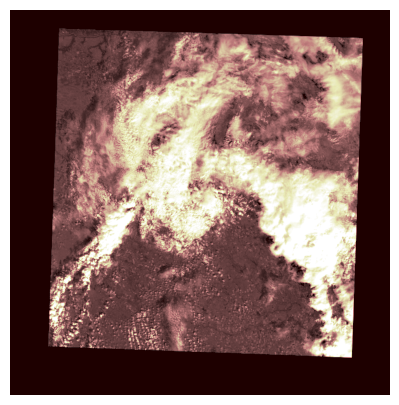

In [ ]:
# Display one sample resized
test = '/content/drive/MyDrive/Spacecraft-team-vision/New_LandSat_Data/landsat_rgb_images_png/3034_3135/LC08_L2SP_030031_20231003_20231011_02_T1_RGB.png'
B4 = rio.open(test)

print(B4.shape)

# Display the band
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(B4.read(1), cmap='pink')
# ax.imshow(B4.read(1))

ax.set_axis_off()